<h2>Etapa 4</h2>
Lucas Luan Belarmino Barbosa - 2021017872


In [1]:
# Carregando os audios separados na etapa 3
import os
import librosa
import os
import pandas as pd

audios = []
diretorio_in = "bons"
for arquivo in os.listdir(diretorio_in):
    if arquivo.endswith(".mp3"):
        # Obtendo os dados do arquivo de áudio
        caminho_arquivo = os.path.join(diretorio_in, arquivo)
        sinal_audio, taxa_amostragem = librosa.load(caminho_arquivo)
        nome_arquivo = os.path.basename(caminho_arquivo)
        audios.append({'nome': nome_arquivo, 'sinal': sinal_audio, 'amostragem': taxa_amostragem})

degluticoes = pd.DataFrame(audios)

In [2]:
# Particionando os audios em pedacos de 0.5 segundos
import numpy as np

audios_particionados = []

for index, audio in degluticoes.iterrows():
    nome = audio['nome']
    sinal = audio['sinal']
    taxa_amostragem = audio['amostragem']

    janela = int(0.25 * taxa_amostragem)
    passo = int(0.125 * taxa_amostragem)
    
    pedaco = []
    tempo = np.arange(len(sinal)) / taxa_amostragem
    for i in range(0, len(sinal), int(passo)):
        fim = i + janela
        if fim > len(sinal):
            break
        else:
            pedaco.append((tempo[i:fim],sinal[i:fim]))

    audios_particionados.append({'nome': nome, 'audio': pedaco, 'sr': taxa_amostragem})
    
particionados_df = pd.DataFrame(audios_particionados)

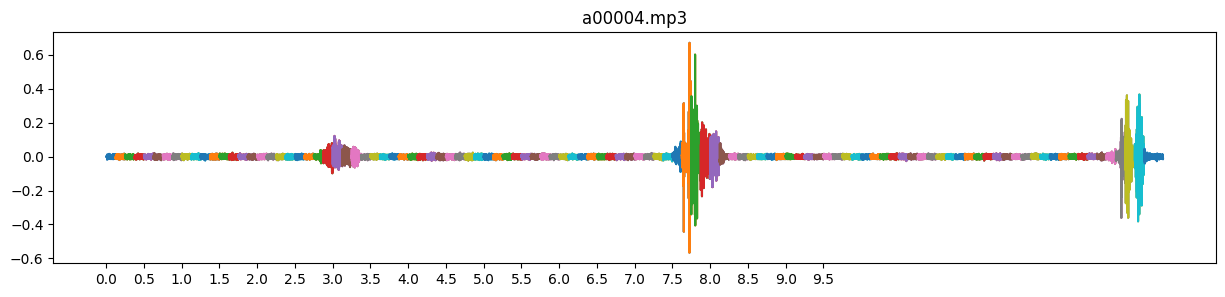

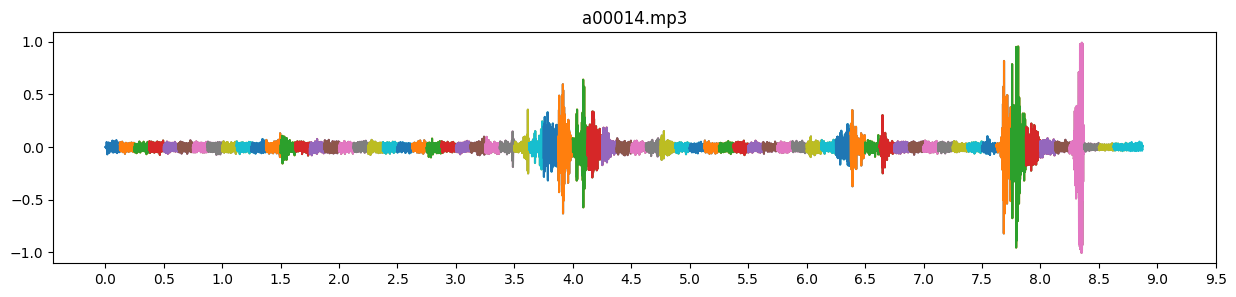

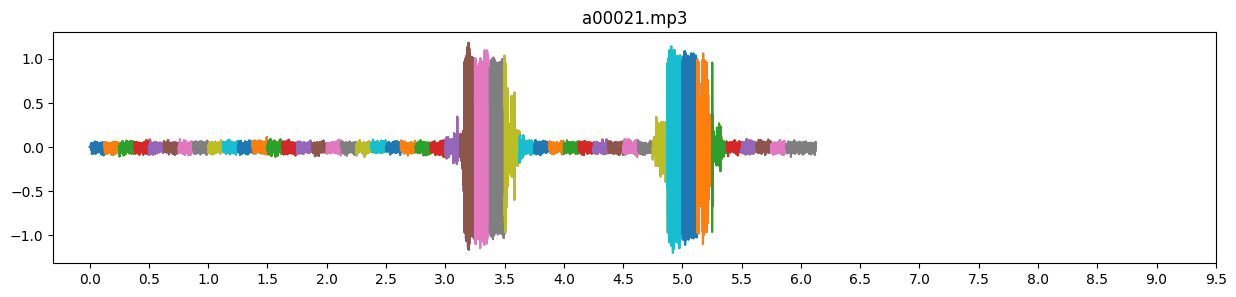

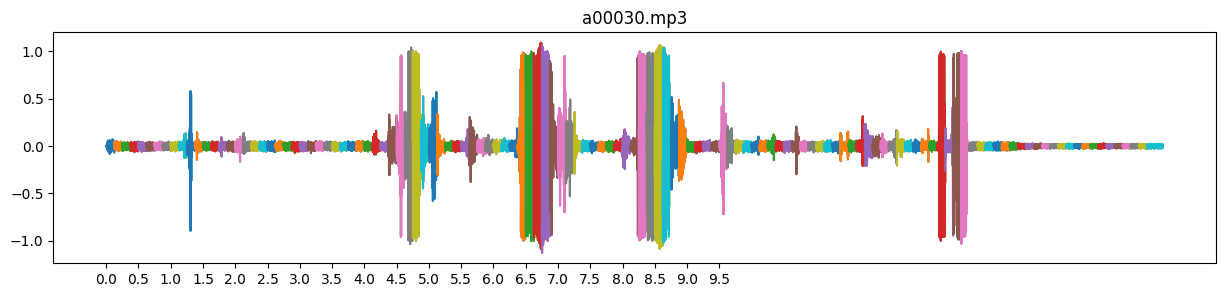

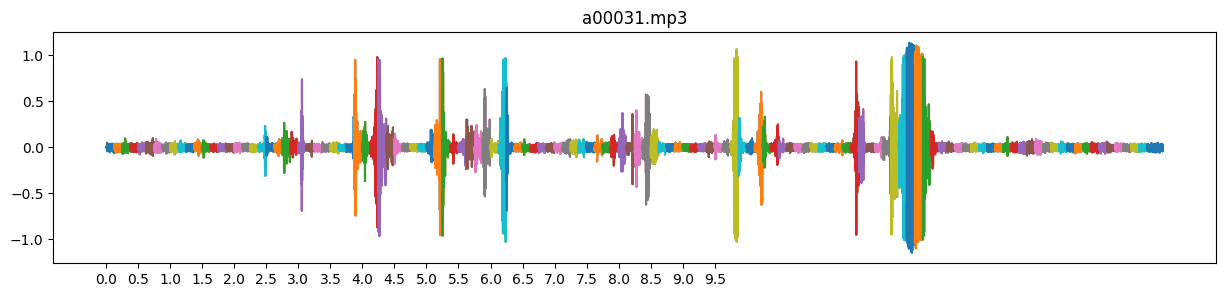

In [3]:
# Plotando os 5 primeiros audios para visualizar o efeito da segmentacao
from matplotlib import pyplot as plt

for i, linha in enumerate(particionados_df['audio']):
    fig, ax = plt.subplots(figsize=(15, 3))

    ax.set_title(degluticoes.iloc[i]['nome'])
    for x, y in linha:
        ax.plot(x, y)
        ax.set_xticks(np.arange(0, 10, 0.5))
    if i == 4:
        break
plt.show()

In [4]:
diretorio_saida = "gerados"

# Cria o diretório de saída se ele não existir
if not os.path.exists(diretorio_saida):
    os.makedirs(diretorio_saida)
else:
    # Remove todos os arquivos do diretório de saída
    for arquivo in os.listdir(diretorio_saida): 
        if os.path.isfile(os.path.join(diretorio_saida, arquivo)):
            os.remove(os.path.join(diretorio_saida, arquivo))

In [6]:
# Treinando o modelo detector de anomalias (degluticoes) nos audios segmentados

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

sckaler = StandardScaler()
X = []
for particao in particionados_df['audio']:
    for _, (_, sinal) in enumerate(particao):
        X.append(sinal)

X = sckaler.fit_transform(X)
X_teste, X_treino = train_test_split(X, test_size=0.3, random_state=42)

isf = IsolationForest(contamination=0.2, random_state=42)
isf.fit(X_treino)

IsolationForest(contamination=0.2, random_state=42)

0it [00:00, ?it/s]

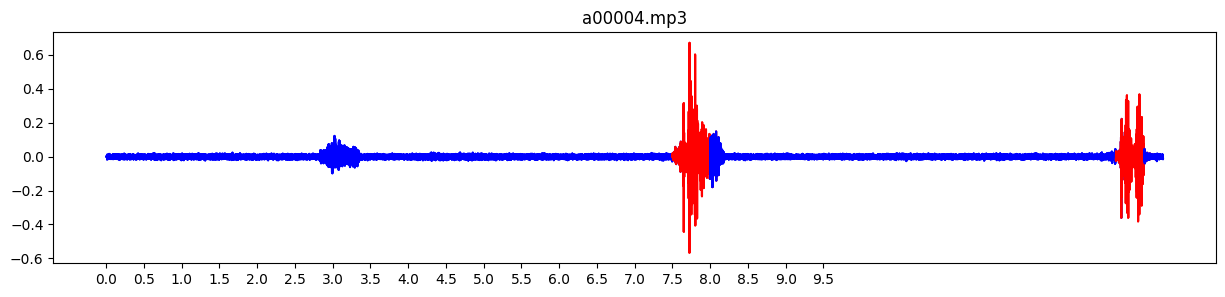

1it [00:00,  2.01it/s]

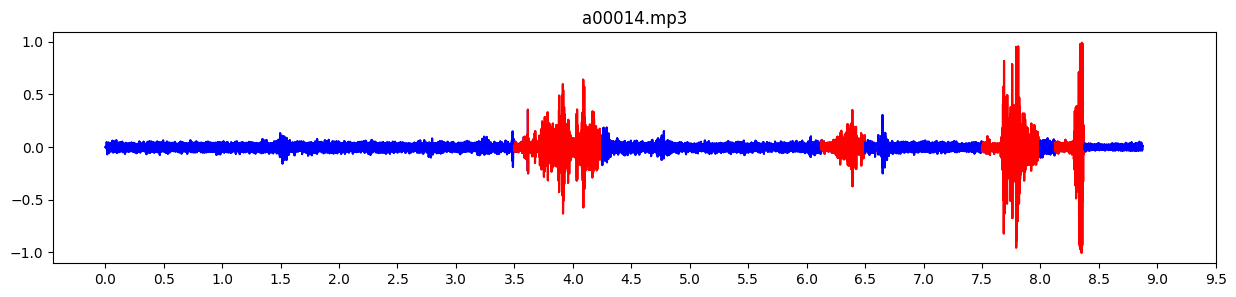

2it [00:00,  2.20it/s]

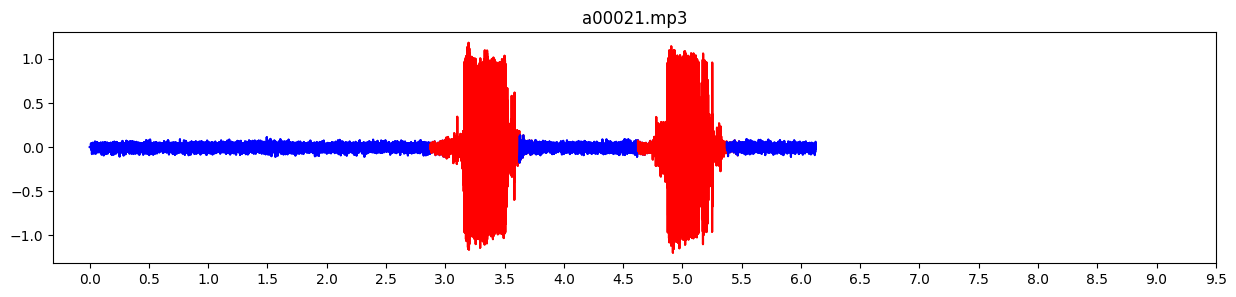

3it [00:01,  2.15it/s]

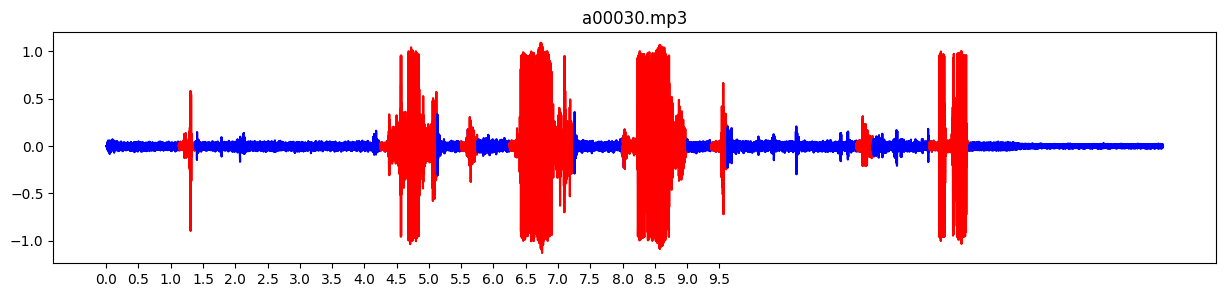

158it [01:16,  2.05it/s]

Fim da geração de imagens


In [7]:
# Plotando os 5 primeiros áudios com marcação nas deglutições e salavando o restante

from tqdm import tqdm

anomalias = isf.predict(X)
anomalias = (anomalias == -1)

n = -1
for i, linha in tqdm(enumerate(particionados_df['audio'])):
    fig, ax = plt.subplots(figsize=(15, 3))

    ax.set_title(degluticoes.iloc[i]['nome'])
    for x, y in linha:
        n += 1
        if anomalias[n]:
            ax.plot(x, y, color='red')
        else:
            ax.plot(x, y, color='blue')
        ax.set_xticks(np.arange(0, 10, 0.5))
    nome_arquivo = degluticoes.iloc[i]['nome']
    fig.savefig(f"{diretorio_saida}/{nome_arquivo}.png")
    if i < 4:
        plt.show()
    else:
        plt.close(fig)
        # break
    plt.close(fig)

print(f"Fim da geração de imagens")

Tentei testar o modelo do SVM (kernels: sigmoid, poly e linear) para encontrar as deglutições, mas o treinamento do modelo estava demorando muito (mais de 6 minutos, além dos travamentos), então resolvi retirá-lo do notebook (a estrutura do código era a mesma utilizada do IsolationForest em diante).